# Self-Driving Car Nanodegree 

## Project: Advanced Lane Detection on curved roads

################

Write a bunch of things to explain project



################

### Import Packages

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
%matplotlib inline

#### Calibration Steps:

In [2]:
##Basic code for global use

nx = 9 #number of inside corners in x
ny = 6 #number of inside corners in y

def get_image_size(img):
    return (img.shape[1], img.shape[0])

In [3]:
def get__calibration_points(cal_images):    
    '''Get imgpoints and objpoints out of list of images for camera_calibration'''
    
    objpoints = [] #object points of real world space
    imgpoints = [] #image points of the image

    objp = np.zeros((nx*ny,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

    offset = 100 #Image offset for boundary spacing of pixels 

    for img_name in cal_images:
        img = mpimg.imread(img_name)
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

        if ret == True:
            imgpoints.append(corners)
            objpoints.append(objp)
    return(imgpoints, objpoints)
    
def get_undistorted_frame(img, imgpoints, objpoints):
    
    '''Calibrate camera using the img_points, objpoints and provide the 
        undistorted image'''
    
    ret, mtx, dist, rvec, tvec = cv2.calibrateCamera(objpoints, imgpoints, get_image_size(img), None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

In [4]:
#Read in the camera images
cal_images = glob.glob('./camera_cal/calibration*.jpg')

#Calibrate the camera using the calibration images
imgpoints, objpoints = get__calibration_points(cal_images)

#### Undistorted Image 


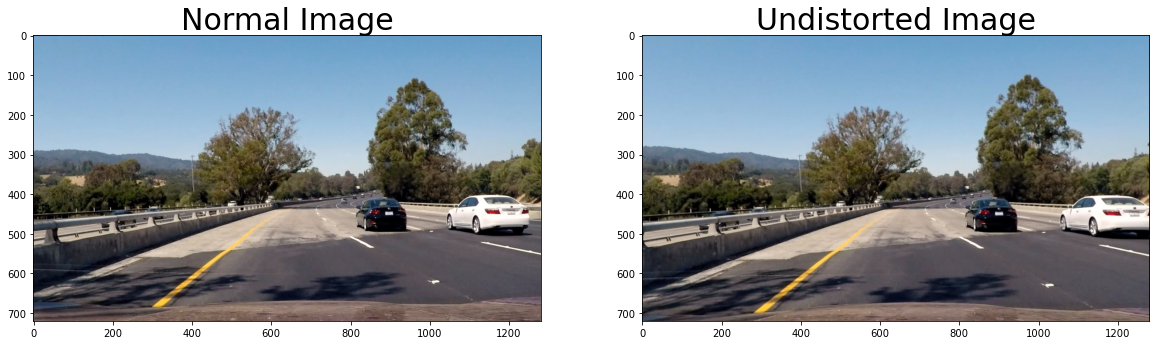

In [5]:
img = mpimg.imread('./test_images/test4.jpg')

undistorted_image = get_undistorted_frame(img, imgpoints, objpoints)

f, (ax1, ax2) = plt.subplots(1,2, figsize=(20,18))

ax1.set_title('Normal Image', fontsize=30)
ax1.imshow(img)
ax2.set_title('Undistorted Image', fontsize=30)
ax2.imshow(undistorted_image)

#### Thresholding

###### 1. Color Space Threshold

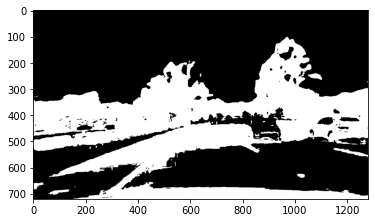

In [6]:
gray = cv2.cvtColor(undistorted_image, cv2.COLOR_BGR2GRAY)
hls = cv2.cvtColor(undistorted_image, cv2.COLOR_RGB2HLS)
H = hls[:,:,0]
L = hls[:,:,1]
S = hls[:,:,2]
HBinary = np.zeros_like(gray)
HBinary[(H >= 0) & (H <= 50)] = 1
plt.imshow(HBinary, cmap='gray')

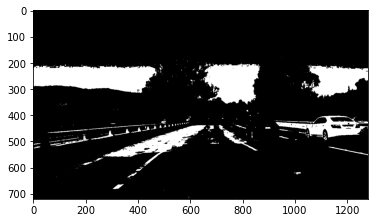

In [7]:
#White Threshold
thresh = (185, 255)
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
Wbinary = np.zeros_like(gray)
Wbinary[(gray > thresh[0]) & (gray <= thresh[1])] = 1
plt.imshow(Wbinary, cmap='gray')

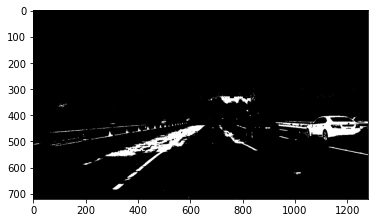

In [8]:
##R Threshold
R = img[:,:,0]
G = img[:,:,1]
B = img[:,:,2]
thresh = (205, 255)
Rbinary = np.zeros_like(R)
Rbinary[(R > thresh[0]) & (R <= thresh[1])] = 1
plt.imshow(Rbinary, cmap='gray')

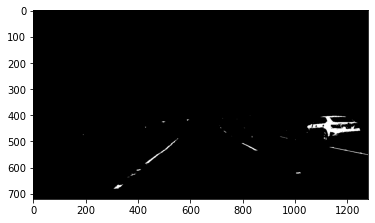

In [9]:
##Y Threshold
R = img[:,:,0]
G = img[:,:,1]
Rthresh = (250, 255)
Gthresh = (250, 255)
Ybinary = np.zeros_like(R)
Ybinary[((G > Gthresh[0]) & (G <= Gthresh[1])) | ((R > Rthresh[0]) & (R <= Rthresh[1]))] = 1
plt.imshow(Ybinary, cmap='gray')

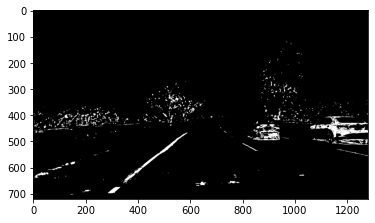

In [10]:
thresh = (160, 255)
Sbinary = np.zeros_like(S)
Sbinary[(S > thresh[0]) & (S <= thresh[1])] = 1
plt.imshow(Sbinary, cmap='gray')

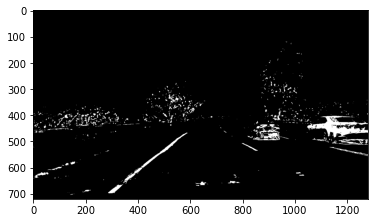

In [11]:
output = np.zeros_like(Sbinary)
output[(Sbinary == 1) | (Rbinary == 1) & (Ybinary ==1)] = 1
plt.imshow(output, cmap='gray')

##### 2. Gradients

In [12]:
def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

In [13]:
img_size = get_image_size(img)
kernel_size = 5
low_threshold = 200
high_threshold = 250
bottom_left = [150,img_size[1]]
top_left = [550,450]
top_right = [750,450]
bottom_right = [1150,img_size[1]]
xcenter = (top_right[0] + top_left[0]) / 2
ycenter = (top_right[1] + bottom_right[1]) / 2

vertices = np.array([[bottom_left, top_left, top_right,bottom_right]], dtype=np.int32)
rho = 2
theta = np.pi/180
threshold = 20
min_line_len = 5
max_line_gap = 6

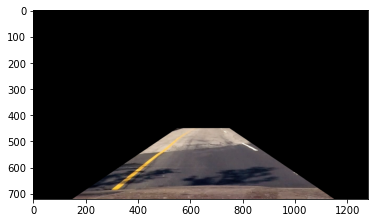

In [14]:
# img = cv2.circle(img, tuple(src[0][1]), 1, (0,255,0), 10) 
plt.imshow(region_of_interest(img, vertices))

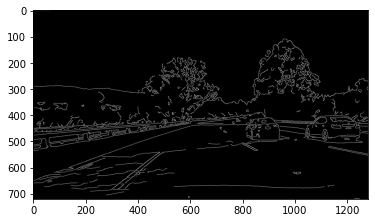

In [15]:
###CANNY IMAGE
blur_img = gaussian_blur(gray, 9)
canny = cv2.Canny(blur_img, 50, 109)
plt.imshow(canny, cmap='gray')

In [16]:
#Gradient Thresholded Image
mag_thresh2 = (40, 80)
dir_thresh = (0.7,1.3)
sobel_kernel = 15
sobelx_thresh = (40,80)
sobely_thresh = (50,70)

sobelx = cv2.Sobel(R, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
absSobelx = np.absolute(sobelx)

sobely = cv2.Sobel(R, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
absSobely = np.absolute(sobely)


scaledSobelx = np.uint8(255*absSobelx/np.max(absSobelx))
scaledSobely = np.uint8(255*absSobely/np.max(absSobely))

SobelXBinary = np.zeros_like(scaledSobelx)
SobelYBinary = np.zeros_like(scaledSobely)
SobelXBinary[(scaledSobelx >= sobelx_thresh[0]) & (scaledSobelx <= sobelx_thresh[1])] = 1
SobelYBinary[(scaledSobely >= sobely_thresh[0]) & (scaledSobely <= sobely_thresh[1])] = 1

# f, (ax1,ax2) = plt.subplots(1,2, figsize=(15,12))
# ax1.imshow(SobelXBinary)
# ax2.imshow(SobelYBinary)

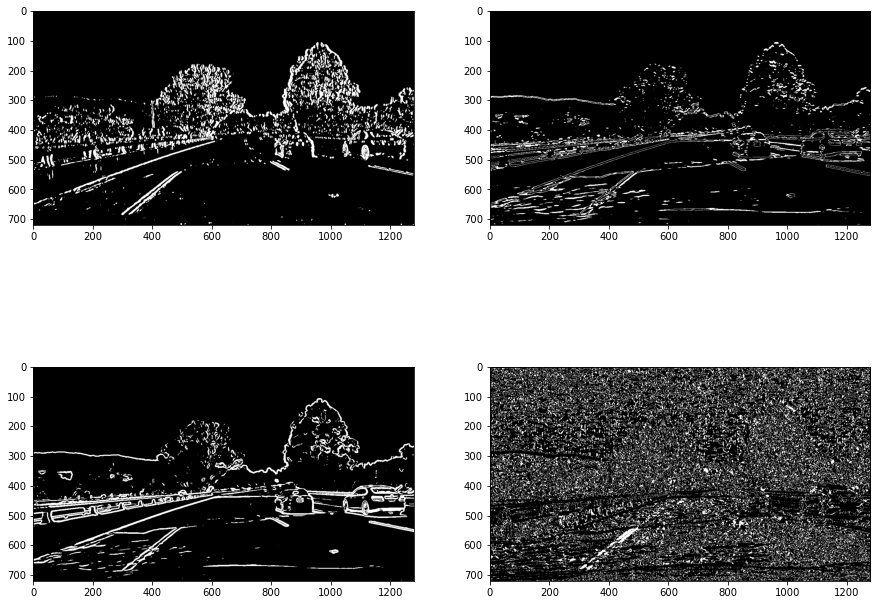

In [17]:
sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

gradSobelX = np.sqrt(sobelx**2)
gradSobelY = np.sqrt(sobely**2)
gradmag = np.sqrt(sobelx**2 + sobely**2)

scale_factorx = np.max(gradSobelX)/255 
scale_factory = np.max(gradSobelY)/255 
scale_factor = np.max(gradmag)/255 

gradSobelX = (gradSobelX/scale_factor).astype(np.uint8) 
gradSobelY = (gradSobelY/scale_factor).astype(np.uint8) 
gradmag = (gradmag/scale_factor).astype(np.uint8) 

absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
GradMagBinary = np.zeros_like(gradmag)
GradSobelXBinary = np.zeros_like(gradmag)
GradSobelYBinary = np.zeros_like(gradmag)
GradDirBinary = np.zeros_like(gradmag)

GradSobelXBinary[(gradSobelX >= 20) & (gradSobelX <= 255)] =1
GradSobelYBinary[(gradSobelY >= mag_thresh2[0]) & (gradSobelY <= mag_thresh2[1])] =1
GradMagBinary[(gradmag >= 50) & (gradmag <= 200)] =1
GradDirBinary[(absgraddir >= 0.7) & (absgraddir <= 1.1)] = 1

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(15,12))
ax1.imshow(GradSobelXBinary, cmap='gray')
ax2.imshow(GradSobelYBinary, cmap='gray')
ax3.imshow(GradMagBinary, cmap='gray')
ax4.imshow(GradDirBinary, cmap='gray')

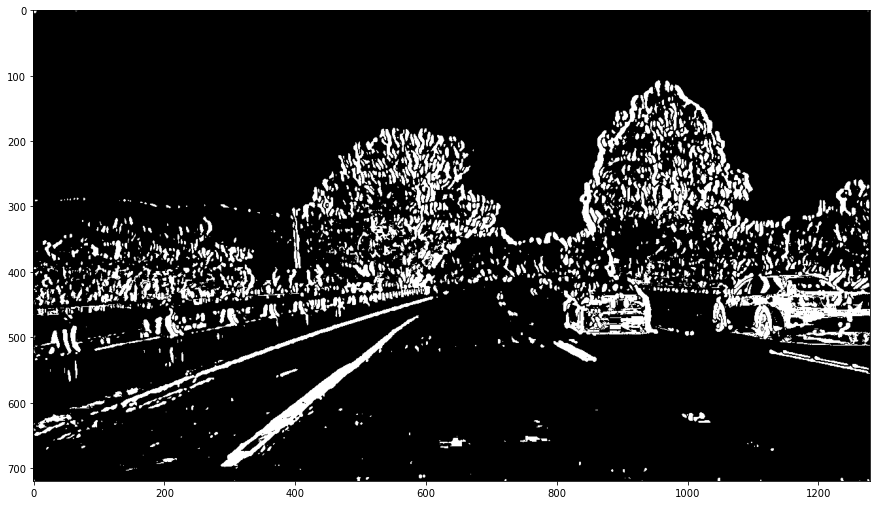

In [18]:
#A mix-match  thresholded image
mixture = np.zeros_like(SobelXBinary)
mixture[(Sbinary == 1) | GradSobelXBinary == 1 | ((GradMagBinary == 1) & (GradDirBinary == 1)) | (output == 1)] = 1
plt.figure(figsize=(15,12))
plt.imshow(mixture, cmap='gray')

In [19]:
# #A mix-match  thresholded image
# mixture = np.zeros_like(SobelXBinary)
# mixture[ ((binary == 1) & (Sbinary == 1)) | (Sbinary == 1) | \
#         ((SobelYBinary == 1) & (SobelXBinary == 1)) | (GradDirBinary == 1)\
#        & (GradMagBinary == 1) | ((GradSobelXBinary == 1) & (GradSobelYBinary == 1))] = 1
# plt.figure(figsize=(15,12))
# plt.imshow(mixture, cmap='gray')

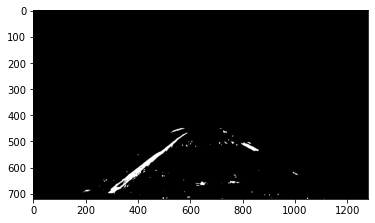

In [20]:
#Masking of the image.
masked_image = region_of_interest(mixture, vertices)
plt.imshow(masked_image, cmap='gray')

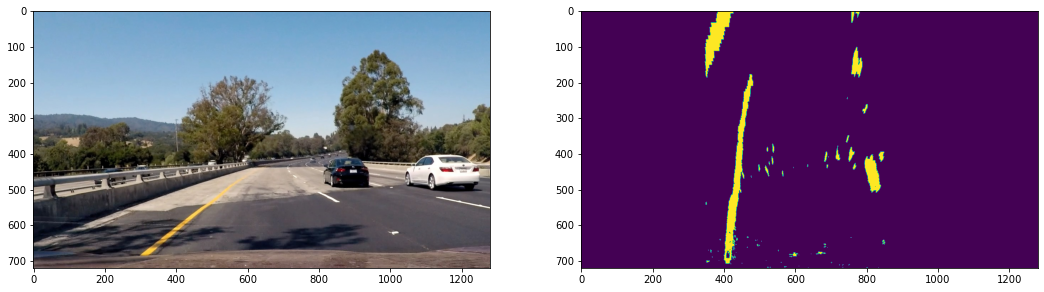

In [21]:
out_vertices =  np.float32([[350, img.shape[0]], [350,0], [850,0], [850, img.shape[0]]])
src = np.float32(vertices)
dst = out_vertices

#Get Perspective Transform needs np.float32 instead of np.array

M = cv2.getPerspectiveTransform(src, dst)
warped_img = cv2.warpPerspective(masked_image, M, get_image_size(img), flags=cv2.INTER_LINEAR)
# img = cv2.line(img,tuple(src[0][0]), tuple(src[0][1]), (0, 255, 0),9)
f, (ax1,ax2) = plt.subplots(1,2, figsize=(18,15))
ax1.imshow(img)
ax2.imshow(warped_img)

Now as you can see, we have got our perspective warped image, and we can now fit a polynomial

### Fitting a Polynomial

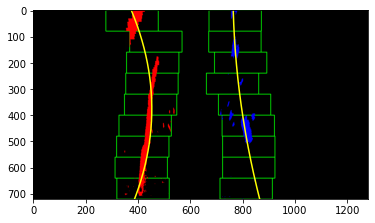

In [29]:
def find_lane_pixels(binary_warped):
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    nwindows = 9
    margin = 100
    minpix = 50
    
    window_height = np.int(binary_warped.shape[0]//nwindows)
    
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    leftx_current = leftx_base
    rightx_current = rightx_base

    left_lane_inds = []
    right_lane_inds = []

    for window in range(nwindows):
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        print('Avoiding an Error here!')
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    
    global leftLine, rightLine
    
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        leftLine.detected = True
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        rightLine.detected = True
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty
    
    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')

    return out_img


out_img = fit_polynomial(warped_img)

plt.imshow(out_img)

In [32]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None 

#Global Line Declarations
leftLine = Line()
rightLine = Line()

In [33]:
def fit_poly(img_shape, leftx, lefty, rightx, righty):
    ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2] 
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty

In [37]:
def search_around_poly(binary_warped, leftLine, rightLine):
    left_fit = leftLine.current_fit if leftLine.current_fit == False else np.array([False])
    right_fit = rightLine.current_fit if rightLine.current_fit == False else np.array([False])
    
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    print(left_fit)
    print(right_fit)
    print(nonzeroy)
    search_area_left = left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] 
    search_area_right = right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2]
    left_lane_inds = (((search_area_left - margin) < nonzerox) & (nonzerox < (search_area_left + margin)))
    right_lane_inds = (((search_area_right - margin) < nonzerox) & (nonzerox < (search_area_right + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
#     ## Visualization ##
#     # Create an image to draw on and an image to show the selection window
#     out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
#     window_img = np.zeros_like(out_img)
#     # Color in left and right line pixels
#     out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
#     out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

#     # Generate a polygon to illustrate the search window area
#     # And recast the x and y points into usable format for cv2.fillPoly()
#     left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
#     left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
#                               ploty])))])
#     left_line_pts = np.hstack((left_line_window1, left_line_window2))
#     right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
#     right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
#                               ploty])))])
#     right_line_pts = np.hstack((right_line_window1, right_line_window2))

#     # Draw the lane onto the warped blank image
#     cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
#     cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
#     result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
#     # Plot the polynomial lines onto the image
#     plt.plot(left_fitx, ploty, color='yellow')
#     plt.plot(right_fitx, ploty, color='yellow')
#     ## End visualization steps ##
    
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    plt.imshow(result)
    
    return result

[False]
[False]
[  0   0   0 ... 719 719 719]


IndexError: index 1 is out of bounds for axis 0 with size 1

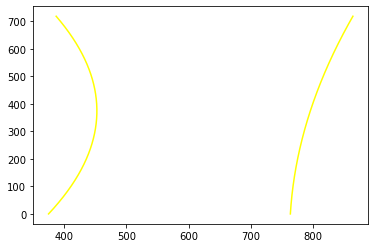

In [38]:
fit_polynomial(warped_img)
leftLine.detected = True
rightLine.detected = True
search_around_poly(warped_img, leftLine, rightLine)

In [39]:
def detect_line_in_frame(binary_warped):
    if (leftLine.detected != True) & (rightLine.detected != True):
        plt.imshow(fit_polynomial(binary_warped, leftLine, rightLine))
        leftLine.detected = True
        rightLine.detected = True
    else:
        plt.imshow(search_around_poly(binary_warped, leftLine, rightLine))

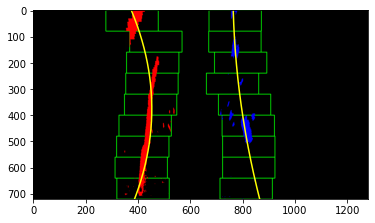

In [27]:
detect_line_in_frame(warped_img)

In [55]:
# def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0,255)):
    
#     gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
#     if orient == 'x':
#         sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
#     else:
#         sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

#     absSobel = np.absolute(sobel)

#     scaledSobel = np.uint8(255*absSobel/np.max(absSobel))

#     binary_output = np.zeros_like(scaledSobel)
#     binary_output[(scaledSobel >= thresh[0]) & (scaledSobel <= thresh[1])] = 1
#     # 6) Return this mask as your binary_output image
#     return binary_output

# sobel_img = abs_sobel_thresh(hls, orient='y', sobel_kernel=5, thresh=(50,80))
# plt.imshow(sobel_img, cmap='gray')

In [56]:
# def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
#     # Convert to grayscale
#     gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
#     # Take both Sobel x and y gradients
#     sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
#     sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
#     # Calculate the gradient magnitude
#     gradmag = np.sqrt(sobelx**2 + sobely**2)
#     # Rescale to 8 bit
#     scale_factor = np.max(gradmag)/255 
#     gradmag = (gradmag/scale_factor).astype(np.uint8) 
#     # Create a binary image of ones where threshold is met, zeros otherwise
#     binary_output = np.zeros_like(gradmag)
#     binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

#     # Return the binary image
#     return binary_output

# gradmag_img = mag_thresh(img, sobel_kernel=5, mag_thresh=(50, 80))
# plt.imshow(gradmag_img, cmap='gray')

In [57]:
# def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
#     # Grayscale
#     gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
#     # Calculate the x and y gradients
#     sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
#     sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
#     # Take the absolute value of the gradient direction, 
#     # apply a threshold, and create a binary image result
#     absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
#     binary_output =  np.zeros_like(absgraddir)
#     binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

#     # Return the binary image
#     return binary_output

# dir_binary = dir_threshold(hls, sobel_kernel=9, thresh=(0.75, 1.0))
# plt.imshow(dir_binary, cmap='gray')

In [58]:
# ksize=9
# gradx = abs_sobel_thresh(hls, orient='x', sobel_kernel=ksize, thresh=(100,200))
# grady = abs_sobel_thresh(hls, orient='y', sobel_kernel=ksize, thresh=(150, 644))
# mag_binary = mag_thresh(hls, sobel_kernel=ksize, mag_thresh=(0, 30))
# dir_binary = dir_threshold(hls, sobel_kernel=ksize, thresh=(0,7, 1.3))#, np.pi/2))

# combined = np.zeros_like(dir_binary)
# combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

In [59]:
# combined_masked = region_of_interest(combined, vertices=vertices)
# plt.imshow(combined_masked, cmap='gray')

In [60]:
# f, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(6, 1, figsize=(70,50))
# # f.tight_layout()
# ax1.imshow(img)
# ax1.set_title('Original Image', fontsize=5)
# ax2.imshow(gradx, cmap='gray')
# ax2.set_title('Thresholded Sobel X.', fontsize=5)
# ax3.imshow(grady, cmap='gray')
# ax3.set_title('Thresholded Sobel Y.', fontsize=5)
# ax4.imshow(mag_binary, cmap='gray')
# ax4.set_title('Thresholded Grad. Mag', fontsize=5)
# ax5.imshow(dir_binary, cmap='gray')
# ax5.set_title('Thresholded Grad. Dir.', fontsize=5)
# ax6.imshow(combined, cmap='gray')
# ax6.set_title('Thresholded Combined.', fontsize=5)


In [61]:
# mag_thresh2 = (50, 80)
# dir_thresh = (0.7,1.3)
# sobel_kernel = 15
# sobelx = cv2.Sobel(S, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
# sobely = cv2.Sobel(S, cv2.CV_64F, 0, 1, ksize=sobel_kernel)


# # binary_output[(sobelx >= thresh[0]) & (sobelx <= thresh[1])] = 1



# # Calculate the gradient magnitude
# gradmag = np.sqrt(sobelx**2 + sobely**2)
# # Rescale to 8 bit
# scale_factor = np.max(gradmag)/255 
# gradmag = (gradmag/scale_factor).astype(np.uint8) 

# # Calculate the direction magnitude
# absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))

# # Create a binary image of ones where threshold is met, zeros otherwise
# binary_output = np.zeros_like(gradmag)
# #### binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1


# binary_output[(gradmag >= mag_thresh2[0]) & (gradmag <= mag_thresh2[1]) \
#               | (absgraddir >= dir_thresh[0]) & (absgraddir <= dir_thresh[1])] = 1


# # binary_output[(sobelx >= mag_thresh2[0]) & (sobelx <= mag_thresh2[1]) \
# #              | (sobely >= mag_thresh2[0]) & (sobely <= mag_thresh2[1])] = 1


# # gradmag_img = mag_thresh(S, sobel_kernel=5, mag_thresh=(50, 80))
# plt.imshow(binary_output, cmap='gray')

In [62]:
# masked_image = region_of_interest(binary_output, vertices=vertices)
# plt.imshow(masked_image, cmap='gray')

In [ ]:
# def on_trackbar(thresh):
#     ksize=9
#     gradx = abs_sobel_thresh(img, orient='x', sobel_kernel=ksize, thresh=thresh)
#     grady = abs_sobel_thresh(img, orient='y', sobel_kernel=ksize, thresh=(150, 644))
#     mag_binary = mag_thresh(img, sobel_kernel=ksize, mag_thresh=(0, 30))
#     dir_binary = dir_threshold(img, sobel_kernel=ksize, thresh=(0, np.pi/2))

#     combined = np.zeros_like(dir_binary)
#     combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
#     cv2.imshow(title_window, combined)

In [20]:
# from __future__ import print_function
# from __future__ import division
# import cv2 as cv
# import argparse
# alpha_slider_max = 100
# title_window = 'Linear Blend'

# # cv2.namedWindow(title_window)
# # trackbar_name = 'Threshold'
# # cv2.createTrackbar(trackbar_name, title_window , 0, 255, on_trackbar)
# # Show some stuff
# # on_trackbar(0)
# # Wait until user press some key
# # cv2.waitKey()

In [21]:
#TRY ABOVE COMMENTS LATER
#BELOW ARE WORKING CODE

In [22]:
# img = mpimg.imread("./camera_cal/calibration20.jpg")
# img_size = (img.shape[1], img.shape[0])

# gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
# plt.imshow(gray)

In [23]:
# def get_undist_unwarp(img):

#     img_size = (img.shape[1], img.shape[0])
#     gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
#     ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

#     if ret == True:
#         imgpoints.append(corners)
#         objpoints.append(objp)

#         chessImg = cv2.drawChessboardCorners(img, (nx,ny), corners, ret)

#         ret, mtx, dist, rvec, tvec = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
#         undist = cv2.undistort(img, mtx, dist, None, mtx)
#         print('Undistorted Image:', len(undist[0]))
#         plt.imshow(undist)

#         offset = 100

#         src = np.float32([corners[0],
#                         corners[nx-1],
#                         corners[-1],
#                         corners[-nx]])

#         dst = np.float32([[offset,offset],
#                          [img_size[0] - offset, offset],
#                          [img_size[0] - offset, img_size[1] - offset],
#                          [offset,img_size[1] - offset]])

#         M = cv2.getPerspectiveTransform(src,dst)
#         warped = cv2.warpPerspective(undist, M, img_size)

#         return warped
#     else:
#         print('Img has squares after reduction')
#         return None

In [24]:
# def on_trackbar(thresh):
#     ksize=9
#     gradx = abs_sobel_thresh(img, orient='x', sobel_kernel=ksize, thresh=(100, 150))
#     grady = abs_sobel_thresh(img, orient='y', sobel_kernel=ksize, thresh=(150, 644))
#     mag_binary = mag_thresh(img, sobel_kernel=ksize, mag_thresh=(0, 30))
#     dir_binary = dir_threshold(img, sobel_kernel=ksize, thresh=(0, np.pi/2))

#     combined = np.zeros_like(dir_binary)
#     combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
#     plt.imshow(combined, cmap='gray')